# Исследовательский анализ популярных компьютерных игр

Добрый день!
В нашем распоряжении данные по компьютерным играм - их названия, платформы, оценки пользователей и критиков. 
Задача - провести анализ имеющихся данных и определить закономерность успешности игр. 
Цель - спланировать продажи на предстоящий период на основе проведенного анализа.
Содержание:
Предобработка данных
Общий анализ
Анализ по регионам
Проверка гипотез
Вывод

In [1]:
import pandas as pd # импорт библиотек
import math
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import seaborn as sns

## Предобработка данных

Начнем с того, что откроем файл и посмотрим на его содержимое. 
Воспользуемся методом try-except, поскольку работаем с разных мест (как локально, так и с рабочей площадки Яндекса)

In [2]:
try: # открываем файл
    games = pd.read_csv('/datasets/games.csv')
except:
    games = pd.read_csv('C:/Users/Елена/Downloads/games.csv')

In [3]:
games.head() # изучаем файл

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Приведем все названия столбцов к нижнему регистру.

In [4]:
games = games.rename(columns=str.lower) # приводим к нижнему регистру
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Посмотрим информацию о файле, какие типы объектов он содержит, сколько пропущено значений

In [5]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Очень большое количество значений пропущено в столбцах с оценкой - как пользовтельской, так и критиков, а также в рейтинге.
Посмотрим чуть позже, что можно будет с этим сделать.
Что касается типа данных -имеет смысл поменять его у года до целочисленного и у оценки пользователей до числового. Не уверена, что год надо менять до типа даты, тк у нас только данные по году, без конкретики до дат, можно оставить и числом, нам это не должно помешать в анализе.

In [6]:
games['user_score'].value_counts() # смотрим какие есть значения у данного столбца с оценкой

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
1.1       2
1.9       2
9.6       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

В столбце с ипользовательской оценкой большое количество занимает значение "tbd", которое означает при переводе с ангнлийского - "будет уточнено". Рискнем и заменим его пока на значение 0,01, чтобы мы смогли привести стоблец к числовому значению.

In [7]:
games['user_score'] = games['user_score'].replace('tbd', -1) # замена значения

In [8]:
games['user_score'] = games['user_score'].astype(float) # замена типа данных

In [9]:
games['user_score'].value_counts()

-1.0    2424
 7.8     324
 8.0     290
 8.2     282
 8.3     254
        ... 
 1.1       2
 1.9       2
 9.6       2
 0.0       1
 9.7       1
Name: user_score, Length: 96, dtype: int64

Для того, чтобы заполнить пропуски в оценках посмотрим на продажи по всем регионам в совокупности. Для этого создадим новый столбец.

In [10]:
games['total_sales'] = games['eu_sales'] + games['na_sales'] + games['jp_sales'] + games['other_sales']

In [11]:
games['critic_score'] = games['critic_score'].fillna(-1)

In [12]:
games['user_score'] = games['user_score'].fillna(-1)

In [13]:
games.duplicated().sum() # поиск дубликатов

0

In [14]:
'Доля пропущенных значений в стоблце с годом выпуска {:.2%}'.format(games['year_of_release'].isna().sum()/len(games['name']))

'Доля пропущенных значений в стоблце с годом выпуска 1.61%'

Аналогично можно поступить с данными в столбцах с годом, жанром и оценкой пользователей.

In [15]:
games = games.dropna(subset=['year_of_release']).reset_index(drop=True)

In [16]:
games = games.dropna(subset=['genre']).reset_index(drop=True)

In [17]:
games['year_of_release'] = games['year_of_release'].astype('int')

In [18]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  float64
 9   user_score       16444 non-null  float64
 10  rating           9768 non-null   object 
 11  total_sales      16444 non-null  float64
dtypes: float64(7), int32(1), object(4)
memory usage: 1.4+ MB


In [19]:
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1.0,-1.0,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1.0,NaN,31.38


Для того, чтобы не оставлять пропуски в рейтинге,заполним пропущенные значения на Unknown. 

In [20]:
games['rating'] = games['rating'].fillna('Unknown')

In [21]:
games.pivot_table(index = 'genre', columns='rating', values='name', aggfunc= 'count')

rating,AO,E,E10+,EC,K-A,M,RP,T,Unknown
genre,,,,,,,,,
Action,1.0,410.0,468.0,1.0,NaN,596.0,NaN,670.0,1161.0
Adventure,NaN,159.0,67.0,2.0,NaN,98.0,NaN,114.0,853.0
Fighting,NaN,8.0,19.0,NaN,NaN,48.0,NaN,357.0,405.0
Misc,NaN,449.0,166.0,5.0,1.0,13.0,NaN,228.0,859.0
Platform,NaN,354.0,141.0,NaN,NaN,3.0,NaN,63.0,317.0
Puzzle,NaN,284.0,42.0,NaN,NaN,NaN,NaN,10.0,233.0
Racing,NaN,576.0,95.0,NaN,NaN,18.0,NaN,167.0,370.0
Role-Playing,NaN,83.0,111.0,NaN,NaN,161.0,NaN,415.0,711.0
Shooter,NaN,47.0,56.0,NaN,NaN,553.0,NaN,340.0,300.0


Таким образом, после проведенной предобработки данных мы получили файл, в котором поставили заглушки в оценки критиков и пользователей и в рейтинги, изменили типы данных, проверили данные на наличие дубликатов. Можно перейти к анализу.

## Общий анализ

Посмотрим сколько игр выпускалось по годам и оценим все ли данные нам нужны и важны.

In [22]:
games.groupby('year_of_release')['name'].count() # сгруппируем по годам выпуска

year_of_release
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     263
1997     289
1998     379
1999     338
2000     350
2001     482
2002     829
2003     775
2004     762
2005     939
2006    1006
2007    1197
2008    1427
2009    1426
2010    1255
2011    1136
2012     653
2013     544
2014     581
2015     606
2016     502
Name: name, dtype: int64

Text(0, 0.5, 'Количество')

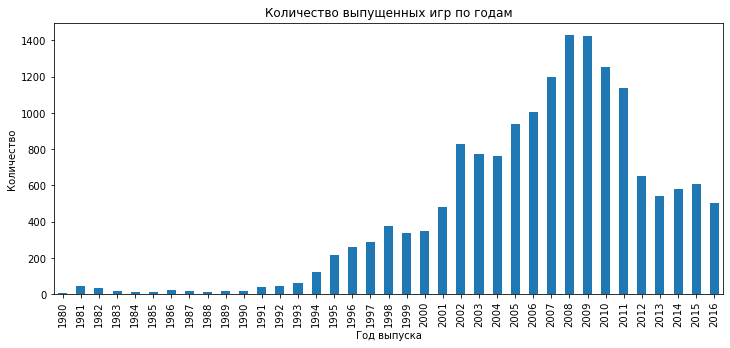

In [23]:
games.groupby('year_of_release')['name'].count().plot(kind='bar', figsize=(12,5)) # график
plt.title(r'Количество выпущенных игр по годам')
plt.xlabel(r'Год выпуска')
plt.ylabel(r'Количество')

Основной пик по выпуску компьютерных игр пришелся на 2008-2009 гг, при этом стабильный рост наблюдается после 2001 года. Правда, в последние несколько лет (2012-2016) можно заметить значительный спад.

Посмотрим на платформы с наибольшими суммарными продажами и выберем основные из них.

In [24]:
games_pivot = games.pivot_table(index=['platform'], values ='total_sales', aggfunc=sum).sort_values(by='total_sales', ascending=False)
games_pivot.head(10)

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


Выберем 6 платформ с наибольшими продажами, поскольку, начиная с 7ой платформы количество продаж резко сократилось, и посмотрим их продажи по годам, чтобы определить их "срок жизни".

In [25]:
games_pivot = games.query('platform == ("PS2","X360","PS3","Wii","DS","PS")')
games_pivot = games_pivot.pivot_table(index=['year_of_release'],columns=['platform'], values ='total_sales', aggfunc=sum)
games_pivot.head()

platform,DS,PS,PS2,PS3,Wii,X360
year_of_release,,,,,,
1985,0.02,NaN,NaN,NaN,NaN,NaN
1994,NaN,6.03,NaN,NaN,NaN,NaN
1995,NaN,35.96,NaN,NaN,NaN,NaN
1996,NaN,94.70,NaN,NaN,NaN,NaN
1997,NaN,136.17,NaN,NaN,NaN,NaN


Text(0, 0.5, 'Суммарные продажи')

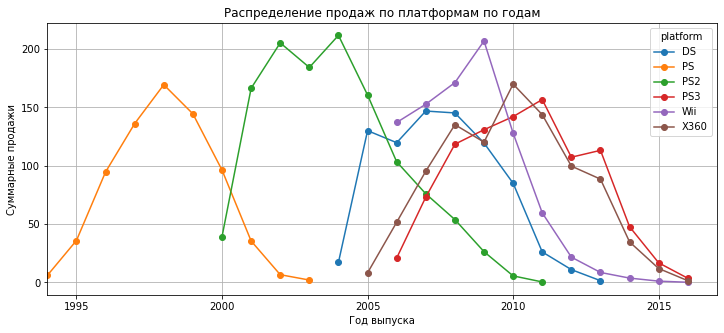

In [26]:
games_pivot.plot(figsize=(12,5), style='o-', grid=True, xlim=(1994,2017)) # строим график
plt.title(r'Распределение продаж по платформам по годам')
plt.xlabel(r'Год выпуска')
plt.ylabel(r'Суммарные продажи')

Как видно из графика выше, у каждой платформы есть характерные взлет,пик и падение ее продаж. Средний "срок жизни" платформы можно оценить в 8-10 лет, при условии, что взлет до пика происходит в первые 2-3 года после выхода платформы. Спад же происходит у всех по-разному - у кого-то быстрее, у кого-то медленнее. В начале исчезновение одной платформы явно было связано с появлением другой. Но после 2005 года стало появляться много платформ одновременно. В период 2005-2015 появилось сразу 4 платформы, которые существовали и существую параллельно.

Оценивая предыдущий анализ по количеству выпущенных игр по годам и распределение продаж по платформам, возьмем для дальнейшего исследования данные после 2002 года. Все, что было ранее неактуальные для нас данные, основываться на них было бы неправильно. Поэтому в дальнейшем не будем их учитывать.

In [27]:
games_new = games.query('year_of_release >= 2012')
games_new.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1.0,-1.0,Unknown,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,-1.0,-1.0,Unknown,14.60
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79


После того, как мы определились с годами, которые оставим для анализа, посмотрим на продажи по этим годам в разрезе платформ. Для этого сначала сделаем сводную таблицу, а затем построим по ней график для визуализации результата.

In [28]:
games_new_pivot = games_new.pivot_table(index='year_of_release',columns=['platform'], values='total_sales', aggfunc='sum')
games_new_pivot

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2012,51.36,11.01,23.22,107.36,NaN,7.69,16.19,21.71,17.56,99.74,NaN
2013,56.57,1.54,12.38,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,NaN,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,NaN,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,NaN,5.25,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


<AxesSubplot:xlabel='year_of_release'>

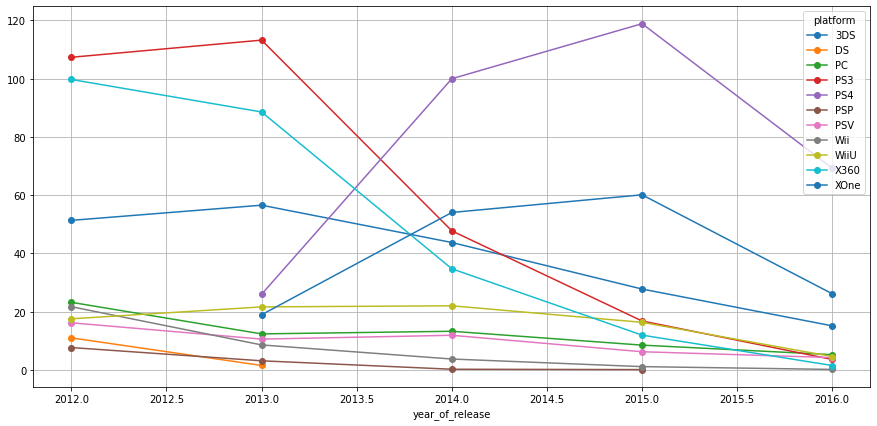

In [29]:
games_new_pivot.plot(style='o-', grid=True, figsize=(15,7))

По графику видно, что в 2015-2016 гг основными по прибыльности платформами были PS4, XOne, 3DS. В то же время все платформы показывают спад продаж к 2016 году, но, возможно, это просто недостаток данных за 2016 год. 
Явное уменьшение количества продаж в 2015-2016 году показывают следующие платформы: PS, Wii, WiiU. Часть платформ уже не продавались совсем - DC, PSP и другие.

Text(0, 0.5, 'Глобальные продажи')

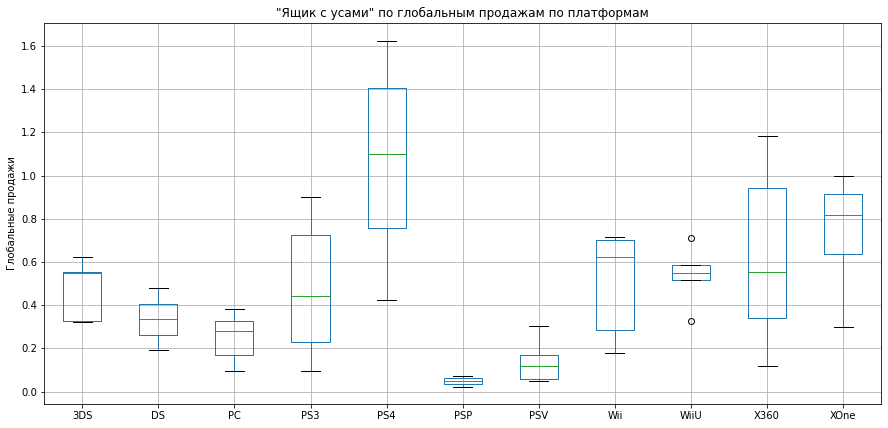

In [30]:
games_new.pivot_table(index='year_of_release',columns='platform', values='total_sales', aggfunc='mean').boxplot(figsize=(15,7))
plt.title(r'"Ящик с усами" по глобальным продажам по платформам')
plt.ylabel(r'Глобальные продажи')

(0.0, 16.0)

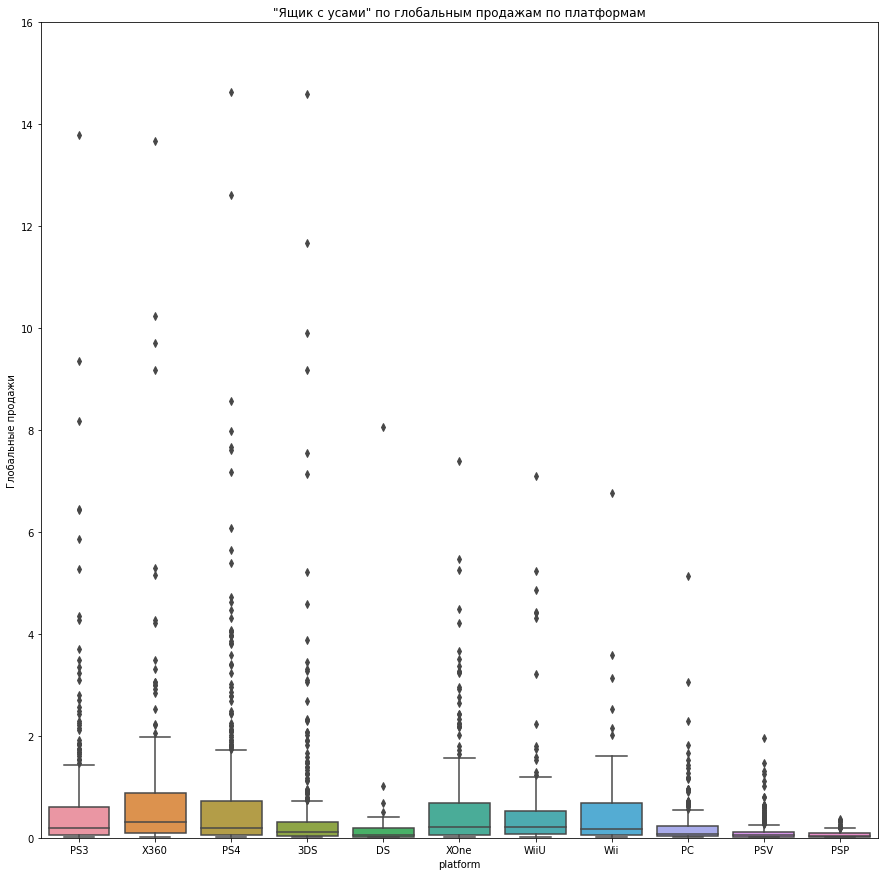

In [31]:
plt.subplots(figsize=(15,15))
sns.boxplot(y=games_new['total_sales'], x=games_new['platform'])
plt.title(r'"Ящик с усами" по глобальным продажам по платформам')
plt.ylabel(r'Глобальные продажи')
plt.ylim(0,16)


(0.0, 1.0)

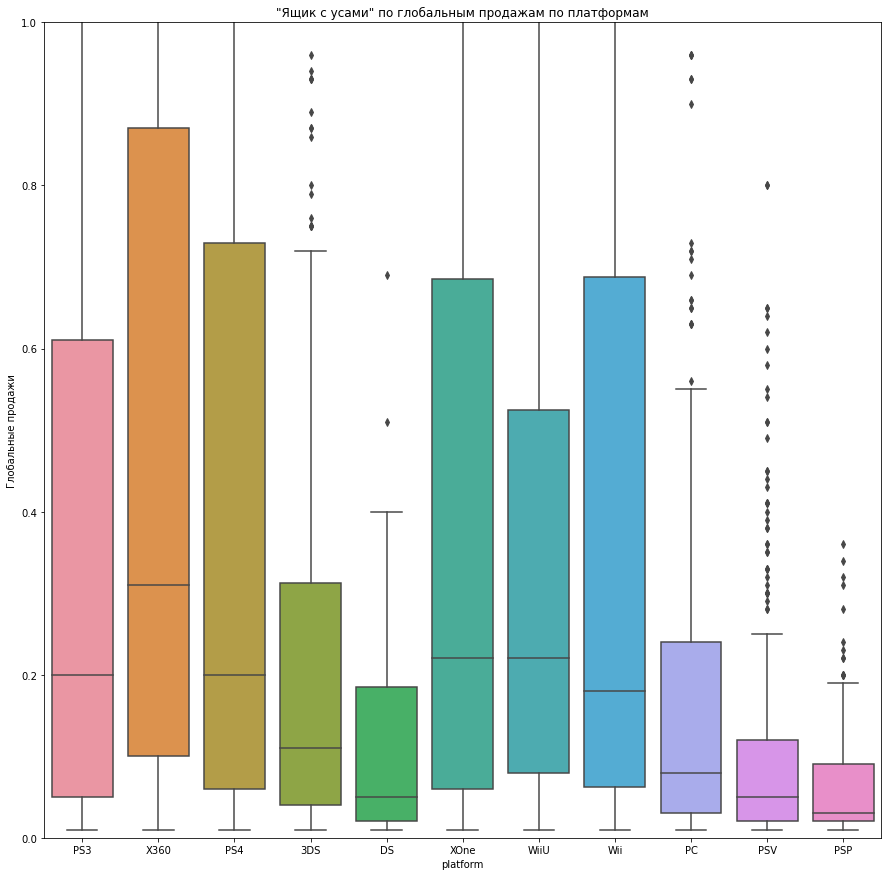

In [32]:
plt.subplots(figsize=(15,15))
sns.boxplot(y=games_new['total_sales'], x=games_new['platform'])
plt.title(r'"Ящик с усами" по глобальным продажам по платформам')
plt.ylabel(r'Глобальные продажи')
plt.ylim(0,1)

Ящик с усами по глобальным продажам по платформам демонстрирует, что почти по всем платформам присутствуют выбросы, и их достаточно много. Выбросов мало только по платформе DS.
Больше всего продаж зафиксировано по платформе Х360. У этой же платформы самая большая медиана (0,3 млн проданных копий). Далее следуют платформы PS4. XOne, Wii и PS3. 
Худшие продажи показывает платформа PSP и PSV.

Определим платформу с самыми большими глобальными продажами.

In [33]:
games_new_pivot = games_new.pivot_table(index='platform', values='total_sales', aggfunc='mean').sort_values(by='total_sales', ascending=False)
games_new_pivot.head(6)

,total_sales
platform,
X360,0.810068
PS4,0.801378
Wii,0.655000
XOne,0.645020
PS3,0.585781
WiiU,0.559116


Выделим данные по платформе X360 в отдельную таблицу и посмотрим на взаимосвязь между продажами и оценкой критиков и пользователей и уберем наши заглушки.

In [34]:
games_one_pl_user = games_new.query('platform == "X360" and user_score != -1')
games_one_pl_user = games_one_pl_user[['user_score','total_sales']]
games_one_pl_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 235 entries, 23 to 16383
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_score   235 non-null    float64
 1   total_sales  235 non-null    float64
dtypes: float64(2)
memory usage: 5.5 KB


In [35]:
games_one_pl_critic = games_new.query('platform == "X360" and critic_score != -1')
games_one_pl_critic = games_one_pl_critic[['critic_score','total_sales']]
games_one_pl_critic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171 entries, 23 to 16342
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   critic_score  171 non-null    float64
 1   total_sales   171 non-null    float64
dtypes: float64(2)
memory usage: 4.0 KB


In [36]:
# Комментарий ревьюера 2
print(len(games_new.query('platform == "X360" and user_score != -1')))
print(len(games_new.query('platform == "X360" and critic_score != -1')))
print(len(games_new.query('platform == "X360" and user_score != -1 and critic_score != -1')))

235
171
171


In [37]:
games_one_pl_user.corr()

,user_score,total_sales
user_score,1.000000,0.006164
total_sales,0.006164,1.000000


Text(0.5, 0, 'Оценки пользователей')

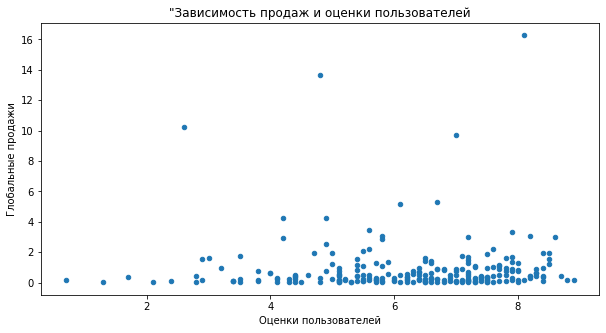

In [38]:
games_one_pl_user.plot(kind='scatter', x ='user_score', y='total_sales', figsize=(10,5))
plt.title(r'"Зависимость продаж и оценки пользователей')
plt.ylabel(r'Глобальные продажи')
plt.xlabel(r'Оценки пользователей')

In [39]:
games_one_pl_critic.corr()

,critic_score,total_sales
critic_score,1.000000,0.360573
total_sales,0.360573,1.000000


Text(0.5, 0, 'Оценки критиков')

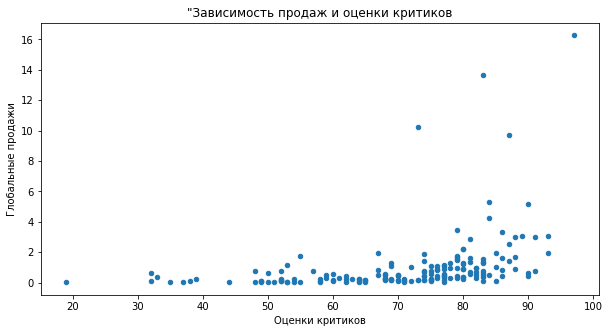

In [40]:
games_one_pl_critic.plot(kind='scatter', x ='critic_score', y='total_sales', figsize=(10,5))
plt.title(r'"Зависимость продаж и оценки критиков')
plt.ylabel(r'Глобальные продажи')
plt.xlabel(r'Оценки критиков')

Из матрицы корреляции и диаграмм рассеяния видно, что между оценкой пользователей и продажами по выбранной платформе X360 взаимосвязь отсутствует, что кажется странным. Однако, можно наблюдать небольшую взаимосвязь между оценкой критиков и продажами, но она так же не очень велика.
Посмотрим, что с взаимозависимостью по остальным платформам.

array([[<AxesSubplot:xlabel='critic_score', ylabel='critic_score'>,
        <AxesSubplot:xlabel='user_score', ylabel='critic_score'>,
        <AxesSubplot:xlabel='total_sales', ylabel='critic_score'>],
       [<AxesSubplot:xlabel='critic_score', ylabel='user_score'>,
        <AxesSubplot:xlabel='user_score', ylabel='user_score'>,
        <AxesSubplot:xlabel='total_sales', ylabel='user_score'>],
       [<AxesSubplot:xlabel='critic_score', ylabel='total_sales'>,
        <AxesSubplot:xlabel='user_score', ylabel='total_sales'>,
        <AxesSubplot:xlabel='total_sales', ylabel='total_sales'>]],
      dtype=object)

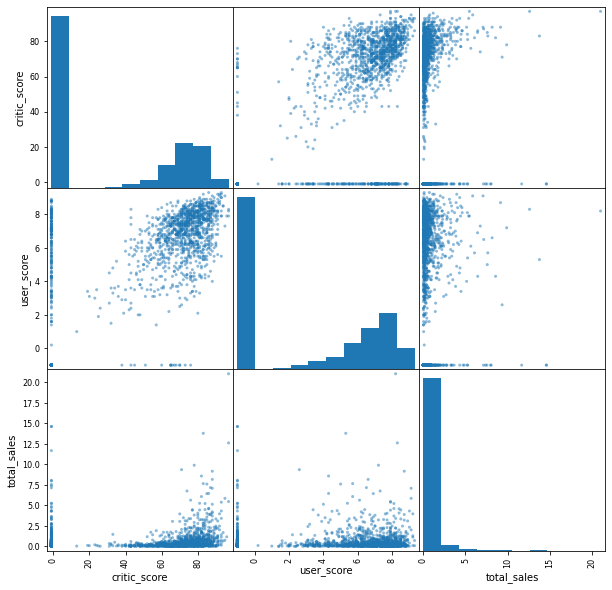

In [41]:
pd.plotting.scatter_matrix(games_new.query('platform != "X360"')[['critic_score','user_score','total_sales']], figsize=(10,10))

In [42]:
plat_m = ['PS4','Wii','XOne','PS3','WiiU']
for pl in plat_m:
    print(pl)
    data_user = games_new.query('user_score != -1').loc[games_new['platform'] == pl][['user_score','total_sales']]
    data_critic = games_new.query('critic_score != -1').loc[games_new['platform'] == pl][['critic_score','total_sales']] 
    print(data_user.corr())
    print()
    print(data_critic.corr())
    print('____________')

PS4
             user_score  total_sales
user_score     1.000000    -0.031957
total_sales   -0.031957     1.000000

              critic_score  total_sales
critic_score      1.000000     0.406568
total_sales       0.406568     1.000000
____________
Wii
             user_score  total_sales
user_score     1.000000     0.296197
total_sales    0.296197     1.000000

              critic_score  total_sales
critic_score      1.000000    -0.424341
total_sales      -0.424341     1.000000
____________
XOne
             user_score  total_sales
user_score     1.000000    -0.068925
total_sales   -0.068925     1.000000

              critic_score  total_sales
critic_score      1.000000     0.416998
total_sales       0.416998     1.000000
____________
PS3
             user_score  total_sales
user_score     1.000000    -0.005144
total_sales   -0.005144     1.000000

              critic_score  total_sales
critic_score      1.000000     0.331497
total_sales       0.331497     1.000000
____________
Wii

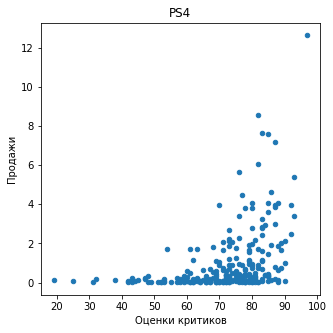

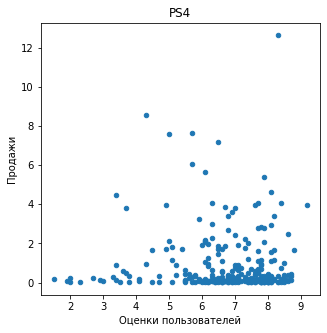

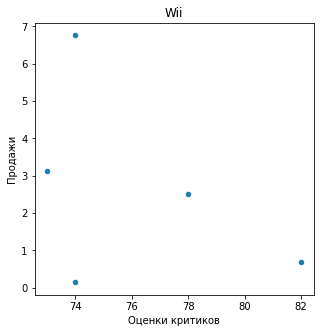

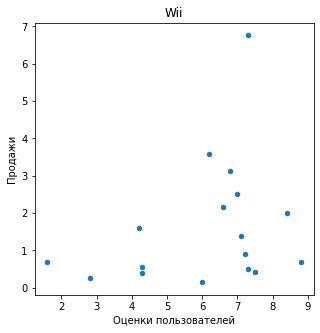

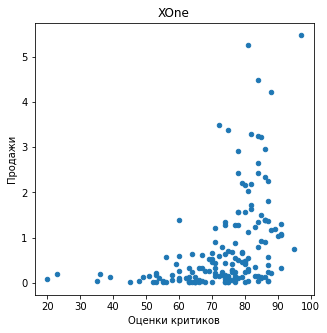

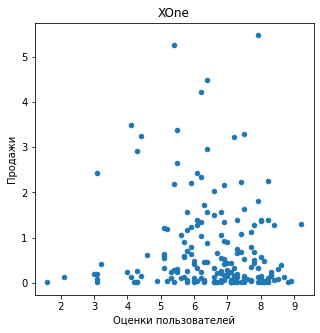

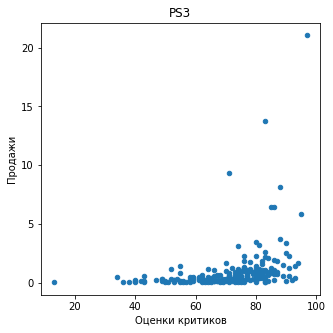

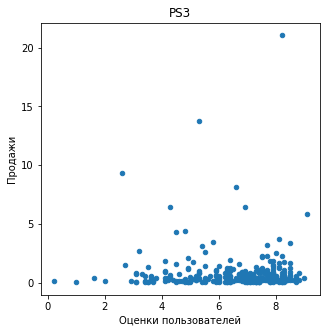

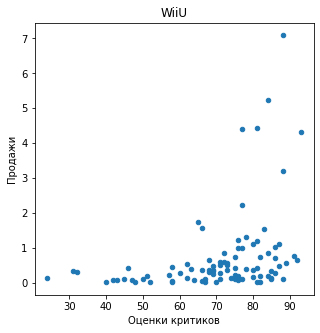

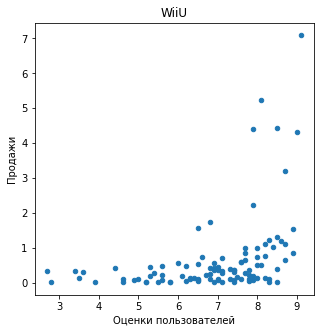

In [43]:
plat_m = ['PS4','Wii','XOne','PS3','WiiU']
for pl in plat_m:
    data_user = games_new.query('user_score != -1').loc[games_new['platform'] == pl][['user_score','total_sales']]
    data_critic = games_new.query('critic_score != -1').loc[games_new['platform'] == pl][['critic_score','total_sales']] 
    data_critic.plot(kind='scatter', x ='critic_score', y='total_sales', figsize=(5,5), title=pl)
    plt.ylabel(r'Продажи')
    plt.xlabel(r'Оценки критиков')
    data_user.plot(kind='scatter', x ='user_score', y='total_sales', figsize=(5,5), title=pl)
    plt.ylabel(r'Продажи')
    plt.xlabel(r'Оценки пользователей')

Из матрицы корреляции и диаграмм рассеяния видно, что между оценкой пользователей и продажами взаимозависимость есть только у двух платформ - WiiU и Wii, и то достаточно небольшая. Однако, аналогично нашей диаграмме рассеяния по платформе Х360 можно наблюдать небольшую взаимосвязь между оценкой критиков и продажами, а у платформы Wii взаимосвязь даже обратная (продажи растут с уменьшением оценки критиков).

Теперь перейдем к анализу жанров.

In [44]:
games_new.pivot_table(index='genre', values='total_sales', aggfunc=('median', 'count')).sort_values(by='median', ascending=False)

,count,median
genre,,
Shooter,235,0.440
Sports,268,0.240
Platform,85,0.210
Role-Playing,370,0.140
Racing,115,0.140
Fighting,109,0.130
Action,1031,0.120
Misc,192,0.120
Simulation,80,0.120


Text(0, 0.5, '')

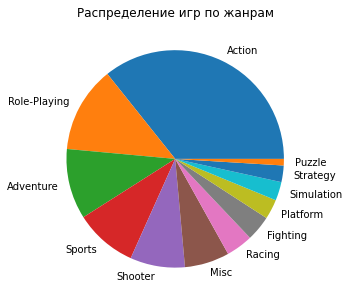

In [45]:
games_new.pivot_table(index='genre', values='total_sales', aggfunc=('median', 'count')).sort_values(by='count', ascending=False)['count'].plot(kind='pie', figsize=(10,5))
plt.title(r'Распределение игр по жанрам')
plt.ylabel(r'')

Text(0, 0.5, 'Суммарные глобальные продажи')

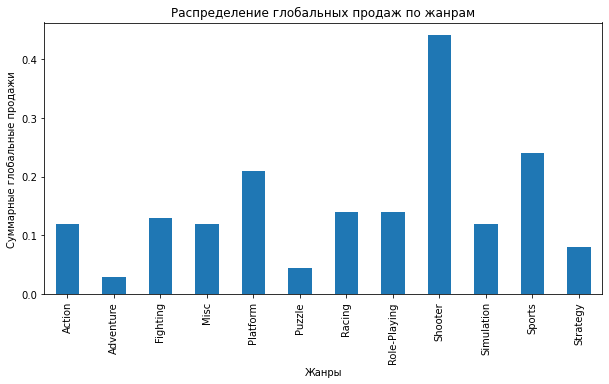

In [46]:
games_new.pivot_table(index='genre', values='total_sales', aggfunc=('median', 'count'))['median'].plot(kind='bar', figsize=(10,5))
plt.title(r'Распределение глобальных продаж по жанрам')
plt.xlabel(r'Жанры')
plt.ylabel(r'Суммарные глобальные продажи')

(0.0, 1.0)

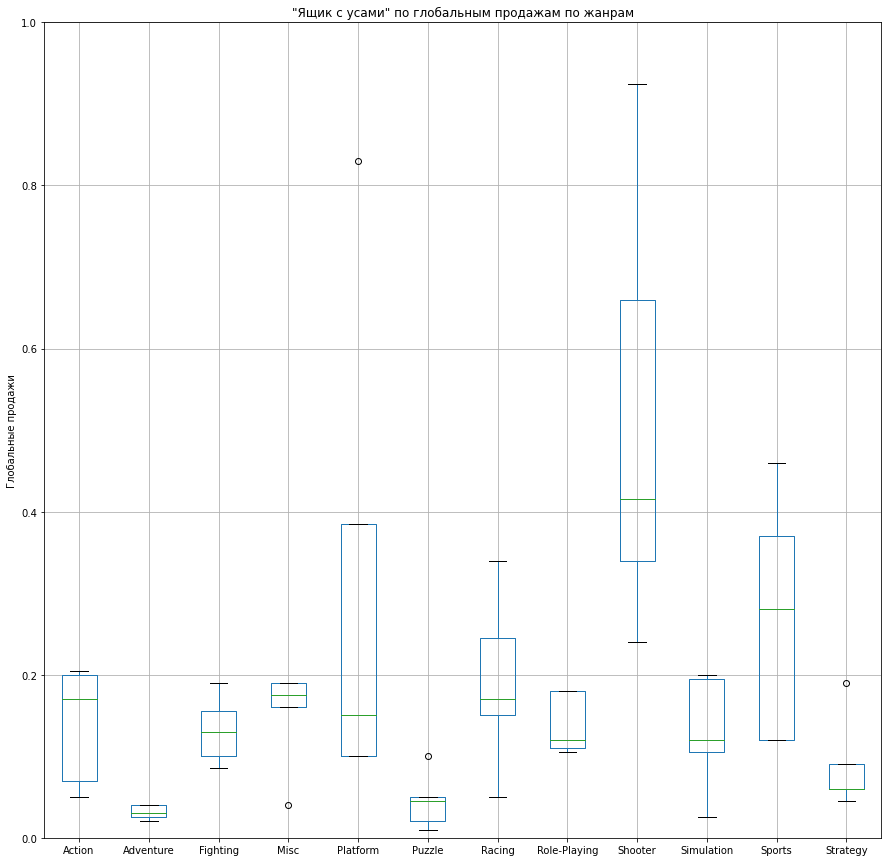

In [47]:
games_new.pivot_table(index='year_of_release',columns='genre' ,values='total_sales', aggfunc=('median')).boxplot(figsize=(15,15))
plt.title(r'"Ящик с усами" по глобальным продажам по жанрам')
plt.ylabel(r'Глобальные продажи')
plt.ylim(0, 1)

Самым популярным жанром по количеству выпущенных игр является Action, следом за ним идет Role-Playing. А вот с точки зрения  продаж лидирует Shooter. Если присмотреться к диаграмме размаха, то можно заметить, что у Shooter достаточно много продаж больше медианы и в целом разброс значений очень большой. Совсем небольшие продажи у Misc, Adventure, Puzzle и Strategy. У последних двух, правда, можно наблюдать выбросы, которые говорят о небольших количестваз, но крупных продажах. Также очень интересный выброс заметен у Platform.

Таким образом, мы закончили наш первоначальный анализ данных, который показал нам довольно много интересных вещей, а именно: то, что самой популярной платформой является Х360, платформы "живут" около 10 лет, наиболее интересные жанры компьютерных игр - Actions и Role-Playing с точки зрения количества выпускаемых игр, а по продажам первое место занимают Shooter, и то, что взаимозависимость между оценкой пользователей и продажами очень невелика.

##  Анализ регионов

До этого мы рассматривали продажи по платформам и по жанрам по всем регионам в совокупности. Сейчас же пришло время оценить предпочтения в каждом регионе отдельно. 
Начнем с оценки популярных платформ.

### Определение популярных платформ по регионам

Сгруппируем данные по платформам и рассмотрим сначально отдельно по каждому региону на графике, а затем все вместе.

In [48]:
games_platform = games_new.pivot_table(index='platform', values=('na_sales','eu_sales','jp_sales'), aggfunc='sum')
games_platform.head()

,eu_sales,jp_sales,na_sales
platform,,,
3DS,42.64,87.79,55.31
DS,3.53,3.72,4.59
PC,37.76,0.00,19.12
PS3,106.86,35.29,103.38
PS4,141.09,15.96,108.74


In [49]:
games_platform_na = games_platform.sort_values(by='na_sales')['na_sales'].reset_index() # выделим отдельно регион
games_platform_na

,platform,na_sales
0,PSP,0.13
1,DS,4.59
2,PSV,10.98
3,Wii,17.45
4,PC,19.12
5,WiiU,38.10
6,3DS,55.31
7,XOne,93.12
8,PS3,103.38
9,PS4,108.74


In [50]:
top_na = games_platform_na[games_platform_na['na_sales'] > 50]['platform'] # выделим топ-5 региона
top_na

6      3DS
7     XOne
8      PS3
9      PS4
10    X360
Name: platform, dtype: object

In [51]:
games_platform_na['platform'] = games_platform_na['platform'].where(games_platform_na['platform'].isin(top_na), "Other")
games_platform_na = games_platform_na.groupby('platform')['na_sales'].sum() # отбор в группу Другие и суммирование

In [52]:
games_platform_eu = games_platform.sort_values(by='eu_sales')['eu_sales'].reset_index() # выделим отдельно регион
games_platform_eu

,platform,eu_sales
0,PSP,0.42
1,DS,3.53
2,PSV,11.36
3,Wii,11.92
4,WiiU,25.13
5,PC,37.76
6,3DS,42.64
7,XOne,51.59
8,X360,74.52
9,PS3,106.86


In [53]:
top_eu = games_platform_eu[games_platform_eu['eu_sales'] > 40]['platform'] # выделим топ-5 региона
top_eu

6      3DS
7     XOne
8     X360
9      PS3
10     PS4
Name: platform, dtype: object

In [54]:
games_platform_eu['platform'] = games_platform_eu['platform'].where(games_platform_eu['platform'].isin(top_eu), "Other")
games_platform_eu = games_platform_eu.groupby('platform')['eu_sales'].sum() # отбор в группу Другие и суммирование

In [55]:
games_platform_jp = games_platform.sort_values(by='jp_sales')['jp_sales'].reset_index() # выделим отдельно регион
games_platform_jp 

,platform,jp_sales
0,PC,0.00
1,XOne,0.34
2,X360,1.57
3,Wii,3.39
4,DS,3.72
5,PSP,10.47
6,WiiU,13.01
7,PS4,15.96
8,PSV,21.04
9,PS3,35.29


In [56]:
top_jp = games_platform_jp[games_platform_jp['jp_sales'] > 12]['platform'] # выделим топ-5 региона
top_jp 

6     WiiU
7      PS4
8      PSV
9      PS3
10     3DS
Name: platform, dtype: object

In [57]:
games_platform_jp['platform'] = games_platform_jp['platform'].where(games_platform_jp['platform'].isin(top_jp), "Other")
games_platform_jp = games_platform_jp.groupby('platform')['jp_sales'].sum() # отбор в группу Другие и суммирование

Text(0, 0.5, ' ')

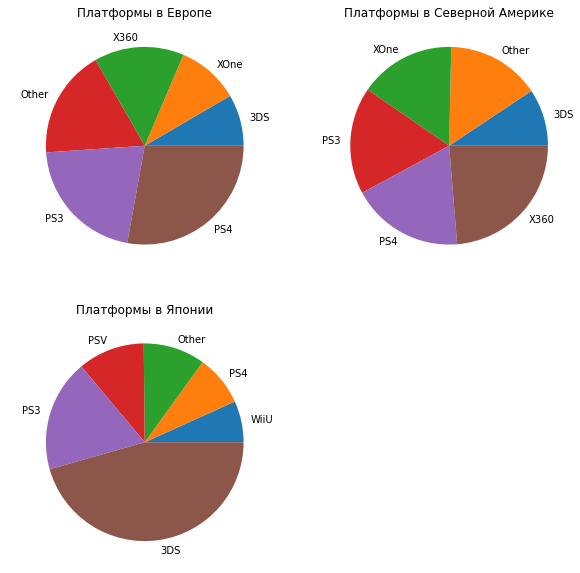

In [58]:
plt.subplot(2,2,1)
games_platform_eu.sort_values().plot(kind='pie', figsize=(10,10))
plt.title(r'Платформы в Европе')
plt.ylabel(r' ')
plt.subplot(2,2,2)
games_platform_na.sort_values().plot(kind='pie', figsize=(10,10))
plt.title(r'Платформы в Северной Америке')
plt.ylabel(r' ')
plt.subplot(2,2,3)
games_platform_jp.sort_values().plot(kind='pie', figsize=(10,10))
plt.title(r'Платформы в Японии')
plt.ylabel(r' ')

Text(0.5, 0, 'Платформы')

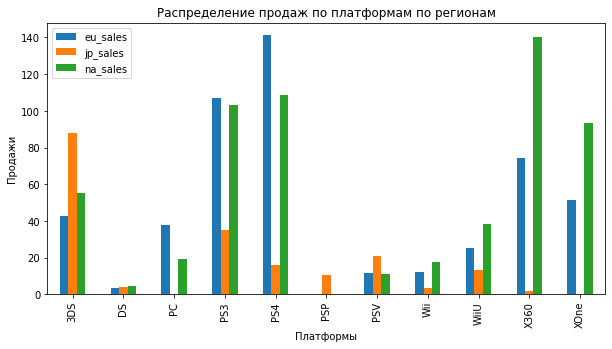

In [59]:
games_platform.plot(kind='bar', figsize=(10,5))
plt.title(r'Распределение продаж по платформам по регионам')
plt.ylabel(r'Продажи')
plt.xlabel(r'Платформы')

Наши графики и анализ показывают, что в разных регионах популярны разные платформы:
Основную долю продаж в Северной Америке составляют платформы X360, PS,PS3,XOne и 3DS, в Европе - PS4, X360, PS3, XOne и 3DS, а в Японии - 3DS, PS3, PS4, PSV и WiiU.

### Определение популярных жанров по регионам

Поступим аналогично, как и с платформами -сгруппируем данные по жанрам и рассмотрим сначально отдельно по каждому региону на графике, а затем все вместе.

In [60]:
games_genre = games_new.pivot_table(index='genre', values=('na_sales', 'eu_sales', 'jp_sales'), aggfunc='sum')
games_genre.head()

,eu_sales,jp_sales,na_sales
genre,,,
Action,159.34,52.80,177.84
Adventure,9.46,8.24,8.92
Fighting,10.79,9.44,19.79
Misc,26.32,12.86,38.19
Platform,21.41,8.63,25.38


In [61]:
games_genre_na = games_genre.sort_values(by='na_sales')['na_sales'].reset_index()
games_genre_na

,genre,na_sales
0,Puzzle,1.13
1,Strategy,4.23
2,Simulation,7.97
3,Adventure,8.92
4,Racing,17.22
5,Fighting,19.79
6,Platform,25.38
7,Misc,38.19
8,Role-Playing,64.00
9,Sports,81.53


In [62]:
top_na = games_genre_na[games_genre_na['na_sales'] > 30]['genre']
top_na

7             Misc
8     Role-Playing
9           Sports
10         Shooter
11          Action
Name: genre, dtype: object

In [63]:
games_genre_na['genre'] = games_genre_na['genre'].where(games_genre_na['genre'].isin(top_na), "Other")
games_genre_na = games_genre_na.groupby('genre')['na_sales'].sum()

In [64]:
games_genre_eu = games_genre.sort_values(by='eu_sales')['eu_sales'].reset_index()
games_genre_eu

,genre,eu_sales
0,Puzzle,1.40
1,Strategy,5.17
2,Adventure,9.46
3,Fighting,10.79
4,Simulation,14.55
5,Platform,21.41
6,Misc,26.32
7,Racing,27.29
8,Role-Playing,48.53
9,Sports,69.09


In [65]:
top_eu = games_genre_eu[games_genre_eu['eu_sales'] > 27]['genre']
top_eu

7           Racing
8     Role-Playing
9           Sports
10         Shooter
11          Action
Name: genre, dtype: object

In [66]:
games_genre_eu['genre'] = games_genre_eu['genre'].where(games_genre_eu['genre'].isin(top_eu), "Other")
games_genre_eu = games_genre_eu.groupby('genre')['eu_sales'].sum()

In [67]:
games_genre_jp = games_genre.sort_values(by='jp_sales')['jp_sales'].reset_index()
games_genre_jp

,genre,jp_sales
0,Puzzle,2.14
1,Racing,2.50
2,Strategy,2.88
3,Sports,8.01
4,Adventure,8.24
5,Platform,8.63
6,Shooter,9.23
7,Fighting,9.44
8,Simulation,10.41
9,Misc,12.86


In [68]:
top_jp = games_genre_jp[games_genre_jp['jp_sales'] > 9.3]['genre']
top_jp

7         Fighting
8       Simulation
9             Misc
10          Action
11    Role-Playing
Name: genre, dtype: object

In [69]:
games_genre_jp['genre'] = games_genre_jp['genre'].where(games_genre_jp['genre'].isin(top_jp), "Other")
games_genre_jp = games_genre_jp.groupby('genre')['jp_sales'].sum()

Text(0, 0.5, ' ')

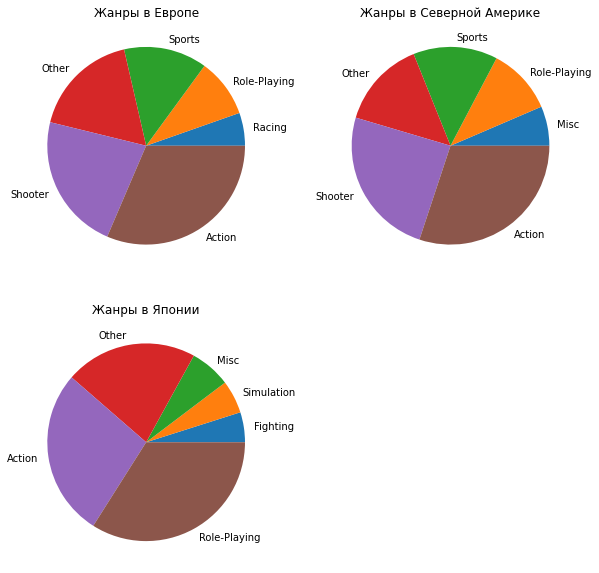

In [70]:
plt.subplot(2,2,1)
games_genre_eu.sort_values().plot(kind='pie', figsize=(10,10))
plt.title(r'Жанры в Европе')
plt.ylabel(r' ')
plt.subplot(2,2,2)
games_genre_na.sort_values().plot(kind='pie', figsize=(10,10))
plt.title(r'Жанры в Северной Америке')
plt.ylabel(r' ')
plt.subplot(2,2,3)
games_genre_jp.sort_values().plot(kind='pie', figsize=(10,10))
plt.title(r'Жанры в Японии')
plt.ylabel(r' ')

Text(0, 0.5, 'Продажи')

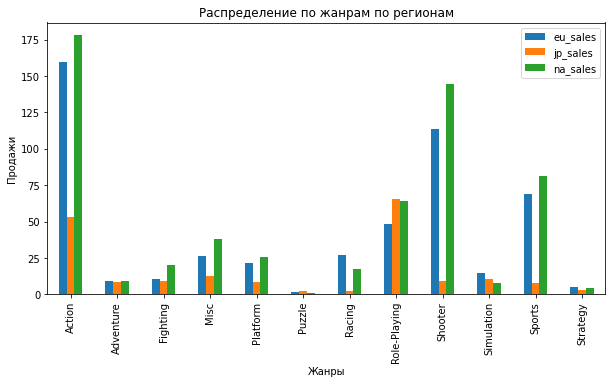

In [71]:
games_genre.plot(kind='bar', figsize=(10,5))
plt.title(r'Распределение по жанрам по регионам')
plt.xlabel(r'Жанры')
plt.ylabel(r'Продажи')

И снова мы наблюдаем различия по регионам. Наибольшую долю продаж в Северной Америке занимают такие жанры как Action, Sports, Shooters, Misc и Role-Playing, в Европе ситуация аналогичная по первым четырем жанрам, а пятым по популярности тут является Racing. 
А вот в стране восходящего солнца опять все иначе - тут предпочтения отдают в основном Role-Playing, а уже потом Action, Misc, Simulation и Fighting.

### Влияние рейтинга ESRB на продажи в каждом регионе.

In [72]:
games_rating = games_new.pivot_table(index='rating', values=('na_sales', 'eu_sales', 'jp_sales'), aggfunc='sum')
games_rating

,eu_sales,jp_sales,na_sales
rating,,,
E,113.03,28.33,114.37
E10+,55.37,8.19,75.70
M,193.96,21.20,231.57
T,52.96,26.02,66.02
Unknown,91.50,108.84,103.31


Text(0, 0.5, 'Продажи')

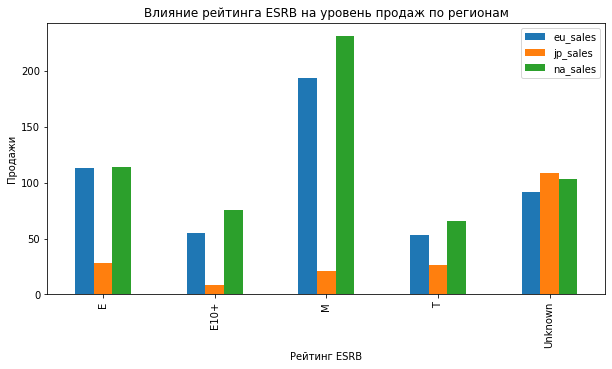

In [73]:
games_rating.plot(kind='bar', figsize=(10,5))
plt.title(r'Влияние рейтинга ESRB на уровень продаж по регионам')
plt.xlabel(r'Рейтинг ESRB')
plt.ylabel(r'Продажи')

А вот с точки зрения рейтинга в Северной Америке и Европе большую долю продаж занимают игры с рейтингом М, а в Японии, к сожалению, неизвестен самый популярный рейтинг.

Таким образом, наш анализ популярных платформ и жанров по регионам показал, что предпочтения в Северной Америке и Европе в чем-то похожи и повторяют друг друга, в то время как в Японии пользователи отдают свое внимание другим платформам и жанрам.

## Проверка гипотез

Мы подошли к концу нашего анализа. Осталось проверить гипотезы по платформам и жанрам.

Наша нулевая гипотеза - средние пользовательские рейтинги платформ PC и XBox One одинаковые. Альтернативная гипотеза - средние пользовательские рейтинги этих платформ различаются.
Посмотрим какого размера наши выборки по этим двум платформам, чтобы решить применять ли параментр equal_var.
Параментр alpha примем равным 0,01.

In [74]:
rating_ps = games_new.query('user_score != -1 and platform == "PC"')['user_score'] 
rating_xone = games_new.query('user_score != -1 and platform == "XOne"')['user_score']

In [75]:
rating_ps.count()

206

In [76]:
rating_xone.count()

182

In [77]:
# Комментарий ревьюера 2
games_new.query('platform == "PC" and user_score != -1').platform.count(), games_new.query(
    'platform == "XOne" and user_score != -1').platform.count()

(206, 182)

In [78]:
alpha = 0.01
result = st.ttest_ind(rating_ps,rating_xone, equal_var=False)
print('p-значение', result.pvalue)
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

p-значение 0.5489537965134912
Не удалось отвергнуть нулевую гипотезу


In [79]:
print('Средний пользовательский рейтинг по платформе PC:',rating_ps.mean())
print('Средний пользовательский рейтинг по платформе XOne:',rating_xone.mean())

Средний пользовательский рейтинг по платформе PC: 6.428640776699027
Средний пользовательский рейтинг по платформе XOne: 6.52142857142857


Не удалось отвергнуть нулевую гипотезу. Статистически значимых различий нет, пока что остаемся в рамках гипотезы, что средние пользовательские значения по этим двум платформам одинаковы.

Наша следующая гипотеза касается жанров.
Нулевая гипотеза - средние пользовательские рейтинги жарнов Action и Sports одинаковы. Альтернативная гипотеза - средние пользовательские рейтинги у этих жанров различаются.
Посмотрим какого размера наши выборки по этим двум жанрам, чтобы решить применять ли параментр equal_var.
Параментр alpha примем равным 0,01.

In [80]:
rating_action = games_new.query('user_score != -1 and genre == "Action"')['user_score']
rating_sports = games_new.query('user_score != -1 and genre == "Sports"')['user_score']

In [81]:
rating_action.count()

523

In [82]:
rating_sports.count()

195

In [83]:
alpha = 0.01
result = st.ttest_ind(rating_action,rating_sports,equal_var=False)
print('p-значение:', result.pvalue)
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 4.24307776572644e-20
Отвергаем нулевую гипотезу


Наш тест показал, что средние пользовательские рейтинги наших двух жанров разные. Пользователи по-разному их оценивают.

In [84]:
print('Средний пользовательский рейтинг по жанру Action:',rating_action.mean())
print('Средний пользовательский рейтинг по жанру Sports:',rating_sports.mean())

Средний пользовательский рейтинг по жанру Action: 6.825047801147237
Средний пользовательский рейтинг по жанру Sports: 5.455897435897437


## Вывод

Мы провели анализ данных по продаже компьютерных игры с точки зрения оценки популярности платформ, жанров, рейтинга как в целом по глобальным мировым продажам, так и отдельно по регионам.

Наш анализ показал, что средний срок жизни платформы составляет до 10 лет, и если в начале развития индустрии компьютерных игр одна платформа исчезала с появлением новой, то сейчас несколько платформ существуют одновременно. Это связано, скорей всего, с тем, что в разных регионах популярны разные платформы. В Северной Америке это платформы X360, PS,PS3,XOne и 3DS, в Европе - PS4, X360, PS3, XOne и 3DS, а в Японии - 3DS, PS3, PS4, PSV и WiiU. То же самое касается и жанра игр - в каждом регионе популярен свой жанр: в Северной Америке и Европе лидируют Action и Sports, а в Японии Role-Playing на первом месте, а уже потом Action. По рейтингу тоже мы получили разные данные для Северной Америки с Европой и Японии.
Также мы обнаружили, что взаимосвязь между пользовательской оценкой и продажами практически отсутствует, в то время как связь между продажами и оценкой критиков имеет место быть. хоть и небольшая.

И в конце нашего исследования мы оценили средние пользовательские оценки по двум разным платформам и жанрам. 

Опираясь на все вышесказанное, можно сделать вывод, что для Северной Америки и Европы потенциально популярным продуктом будет игра с рейтингом M, жанром Action и выпущенная на платформе X360 (Для Америки) или PS4 (для Европы). А для Японии - жанр Role-Playing, платформа - 3DS, но вот рейтинг не известен, к сожалению. И нам не стоит опираться на оценки пользователей, от них продажи не зависят.